## Dataset from Kaggle
* Dataset [Brain Tumor MRI Images 44 Classes](https://www.kaggle.com/datasets/fernando2rad/brain-tumor-mri-images-44c) 

In [6]:
import os
import pandas as pd
import numpy as np
import torch
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.utils import to_categorical
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
import sklearn.metrics as metrics

## Load + Preprocess Dataset

In [7]:
import json 
import os
from pathlib import Path

# your api key
api_key = {
'username':"anna58yt" , # kaggle account just registered
'key':"b854876d62210a798f2bb5de86df8008"}

# uses pathlib Path
kaggle_path = Path('/root/.kaggle')
os.makedirs(kaggle_path, exist_ok=True)

# opens file and dumps python dict to json object 
with open (kaggle_path/'kaggle.json', 'w') as handl:
    json.dump(api_key,handl)

os.chmod(kaggle_path/'kaggle.json', 600)  


In [8]:
! pip install kaggle
!kaggle datasets download -d fernando2rad/brain-tumor-mri-images-44c

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
 90% 169M/188M [00:05<00:00, 45.6MB/s]
100% 188M/188M [00:05<00:00, 34.9MB/s]


In [9]:
import os
current_filename = 'brain-tumor-mri-images-44c.zip'
new_filename = 'brain_tumor.zip'
os.rename(current_filename, new_filename)

In [ ]:
# uploading the unzipped file directly is painfully slow, so instead upload the zip file and unzip here
!unzip 'brain_tumor.zip' -d brain_tumor/

In [13]:
# Set the path to your image folder
image_folder = 'brain_tumor'

# Define the image size and number of classes
img_size = (128, 128)
num_classes = 44

In [14]:
# Function to load and preprocess the images
def load_images(folder_path):
    images = []
    labels = []
    label_names = []
    class_dirs = sorted(os.listdir(folder_path))

    for class_index, class_dir in enumerate(class_dirs):
        class_path = os.path.join(folder_path, class_dir)
        label_names.append(class_dir)
        if os.path.isdir(class_path):
            image_files = os.listdir(class_path)
            for image_file in image_files:
                image_path = os.path.join(class_path, image_file)
                image = Image.open(image_path).convert('RGB')
                image = image.resize(img_size)
                image = np.array(image)
                images.append(image)
                labels.append(class_index)

    return np.array(images), np.array(labels), label_names

In [15]:
# Load and preprocess the images
images, labels, label_names = load_images(image_folder)

# Split the dataset into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

### Look at data lables for generalization
Only the category No Tumor and Meningioma overlaps between the two datasets. 

In [17]:
# Convert labels to one-hot encoding
num_classes = len(np.unique(labels))
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

In [16]:
for i in range(0, len(label_names)):
  print(i, label_names[i])

# Glioma - No equivalence
# Meningioma - 24, 25, 26
# No Tumor/ Normal 42, 43
# Pitutary - No equivalence

0 Astrocitoma T1
1 Astrocitoma T1C+
2 Astrocitoma T2
3 Carcinoma T1
4 Carcinoma T1C+
5 Carcinoma T2
6 Ependimoma T1
7 Ependimoma T1C+
8 Ependimoma T2
9 Ganglioglioma T1
10 Ganglioglioma T1C+
11 Ganglioglioma T2
12 Germinoma T1
13 Germinoma T1C+
14 Germinoma T2
15 Glioblastoma T1
16 Glioblastoma T1C+
17 Glioblastoma T2
18 Granuloma T1
19 Granuloma T1C+
20 Granuloma T2
21 Meduloblastoma T1
22 Meduloblastoma T1C+
23 Meduloblastoma T2
24 Meningioma T1
25 Meningioma T1C+
26 Meningioma T2
27 Neurocitoma T1
28 Neurocitoma T1C+
29 Neurocitoma T2
30 Oligodendroglioma T1
31 Oligodendroglioma T1C+
32 Oligodendroglioma T2
33 Papiloma T1
34 Papiloma T1C+
35 Papiloma T2
36 Schwannoma T1
37 Schwannoma T1C+
38 Schwannoma T2
39 Tuberculoma T1
40 Tuberculoma T1C+
41 Tuberculoma T2
42 _NORMAL T1
43 _NORMAL T2


## CNN Model

In [ ]:
# Define the CNN model
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(img_size[0], img_size[1], 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
# prep for input into fully connected layer
model.add(Flatten())
# 128 neurons that learns high-level features
model.add(Dense(128, activation='relu'))
# num neurons = num classes. softmax produces final probability distribution
model.add(Dense(num_classes, activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
# Train the model

# Check if a GPU is available
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("No GPU found. Please make sure you have enabled GPU acceleration in the Colab notebook settings.")

# Train the model with GPU acceleration
with tf.device('/device:GPU:0'):
    model.fit(x_train, y_train, batch_size=32, epochs=10, validation_data=(x_test, y_test))

Default GPU Device: /device:GPU:0
Epoch 1/10
112/112 [==============================] - 14s 20ms/step - loss: 15.2833 - accuracy: 0.3173 - val_loss: 1.6268 - val_accuracy: 0.5893
Epoch 2/10
112/112 [==============================] - 2s 15ms/step - loss: 0.8794 - accuracy: 0.7737 - val_loss: 0.9261 - val_accuracy: 0.7634
Epoch 3/10
112/112 [==============================] - 2s 15ms/step - loss: 0.2689 - accuracy: 0.9352 - val_loss: 0.7992 - val_accuracy: 0.7991
Epoch 4/10
112/112 [==============================] - 2s 15ms/step - loss: 0.1680 - accuracy: 0.9615 - val_loss: 0.8384 - val_accuracy: 0.7958
Epoch 5/10
112/112 [==============================] - 2s 15ms/step - loss: 0.1130 - accuracy: 0.9810 - val_loss: 0.8444 - val_accuracy: 0.8103
Epoch 6/10
112/112 [==============================] - 2s 15ms/step - loss: 0.0871 - accuracy: 0.9872 - val_loss: 0.7543 - val_accuracy: 0.8147
Epoch 7/10
112/112 [==============================] - 2s 15ms/step - loss: 0.0654 - accuracy: 0.9900 - val

In [18]:
# Save the model
model.save("my_model.h5")

NameError: ignored

In [ ]:
# Save to local machine
from google.colab import files
files.download("my_model.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Model Evaluation

In [19]:
# Load the saved model
model = keras.models.load_model("my_model.h5")

In [ ]:
# Calculate loss + accuracy
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.9177536964416504
Test accuracy: 0.8080357313156128


In [ ]:
print(x_test, y_test)

In [ ]:
# Generate predictions on the test set
y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)  # Convert one-hot encoded predictions to labels

# Convert test labels to labels instead of one-hot encoding
y_true = np.argmax(y_test, axis=1)

# Compute the confusion matrix
confusion_matrix = metrics.confusion_matrix(y_true, y_pred)

# Define class labels (assuming you have a list of class names)
class_labels = label_names  # Replace with your actual class labels

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(16, 12))
plt.imshow(confusion_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_labels))
plt.xticks(tick_marks, class_labels, rotation=45)
plt.yticks(tick_marks, class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

In [ ]:
# Calculate negative log likelihood
# y_pred_probs = model.predict(x_test)
# nll = -tf.reduce_mean(tf.reduce_sum(y_test * tf.math.log(y_pred_probs), axis=-1))
# print("Negative Log-Likelihood:", nll.numpy())

# Calculate F1 score for each class separately
f1_scores = metrics.f1_score(y_true, y_pred, average=None)

# Calculate the average F1 score
average_f1_score = sum(f1_scores) / len(f1_scores)

print("F1 Scores for Each Class:", f1_scores)
print("Average F1 Score:", average_f1_score)

F1 Scores for Each Class: [0.79452055 0.86956522 0.72222222 0.96551724 0.88888889 0.97142857
 0.77777778 0.66666667 0.76923077 0.85714286 0.85714286 0.25
 0.66666667 0.85714286 0.55555556 0.82758621 0.92307692 0.66666667
 0.71428571 0.66666667 0.28571429 0.83333333 0.88888889 0.53333333
 0.74157303 0.82080925 0.70212766 0.86206897 0.9010989  0.70588235
 0.85714286 0.9        0.8        0.81481481 0.72222222 0.76923077
 0.8        0.85333333 0.76470588 0.875      0.76190476 0.46153846
 0.92173913 0.78181818]
Average F1 Score: 0.7642279839007173


## Attention Map

In [ ]:
#get layer names
for layer in model.layers:
    print(layer.name)

conv2d
max_pooling2d
conv2d_1
max_pooling2d_1
flatten
dense
dense_1


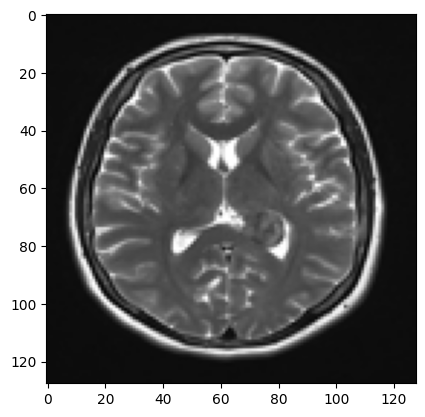

In [ ]:
img = x_test[100]
img = cv2.resize(img, (128, 128))
ax = plt.imshow(img)

In [ ]:
# Convert the image to a tensor and preprocess it
input_image = tf.expand_dims(tf.cast(img, tf.float32), axis=0)
input_image = input_image / 255.0

In [ ]:
def get_activations_at(input_image, i):
  # Load the saved model
  model = keras.models.load_model("my_model.h5")
  
  #index the layer 
  out_layer = model.layers[i]

  # Specify input + output layer; output layer = layer being examined
  inputs, outputs = model.inputs, out_layer.output
  
  #change the output of the model 
  model = tf.keras.models.Model(inputs, outputs)
  
  #return the activations
  return model.predict(input_image)

In [ ]:
def postprocess_activations(activations):

  #using the approach in https://arxiv.org/abs/1612.03928
  output = np.abs(activations)
  output = np.sum(output, axis = -1).squeeze()

  #resize and convert to image 
  output = cv2.resize(output, (128, 128))
  output /= output.max()
  output *= 255
  return 255 - output.astype('uint8')

In [ ]:
def apply_heatmap(weights, img):
  #generate heat maps 
  heatmap = cv2.applyColorMap(weights, cv2.COLORMAP_JET)
  heatmap = cv2.addWeighted(heatmap, 0.7, img, 0.3, 0)
  return heatmap

In [ ]:
def plot_heatmaps(rng):
  level_maps = None
  
  #given a range of indices generate the heat maps 
  for i in rng:
    activations = get_activations_at(input_image, i)
    weights = postprocess_activations(activations)
    heatmap = apply_heatmap(weights, img)
    if level_maps is None:
      level_maps = heatmap
    else:
      level_maps = np.concatenate([level_maps, heatmap], axis = 1)
  plt.figure(figsize=(30, 30))
  plt.axis('off')
  ax = plt.imshow(level_maps)

1/1 [==============================] - 0s 94ms/step


1/1 [==============================] - 0s 58ms/step


1/1 [==============================] - 0s 77ms/step


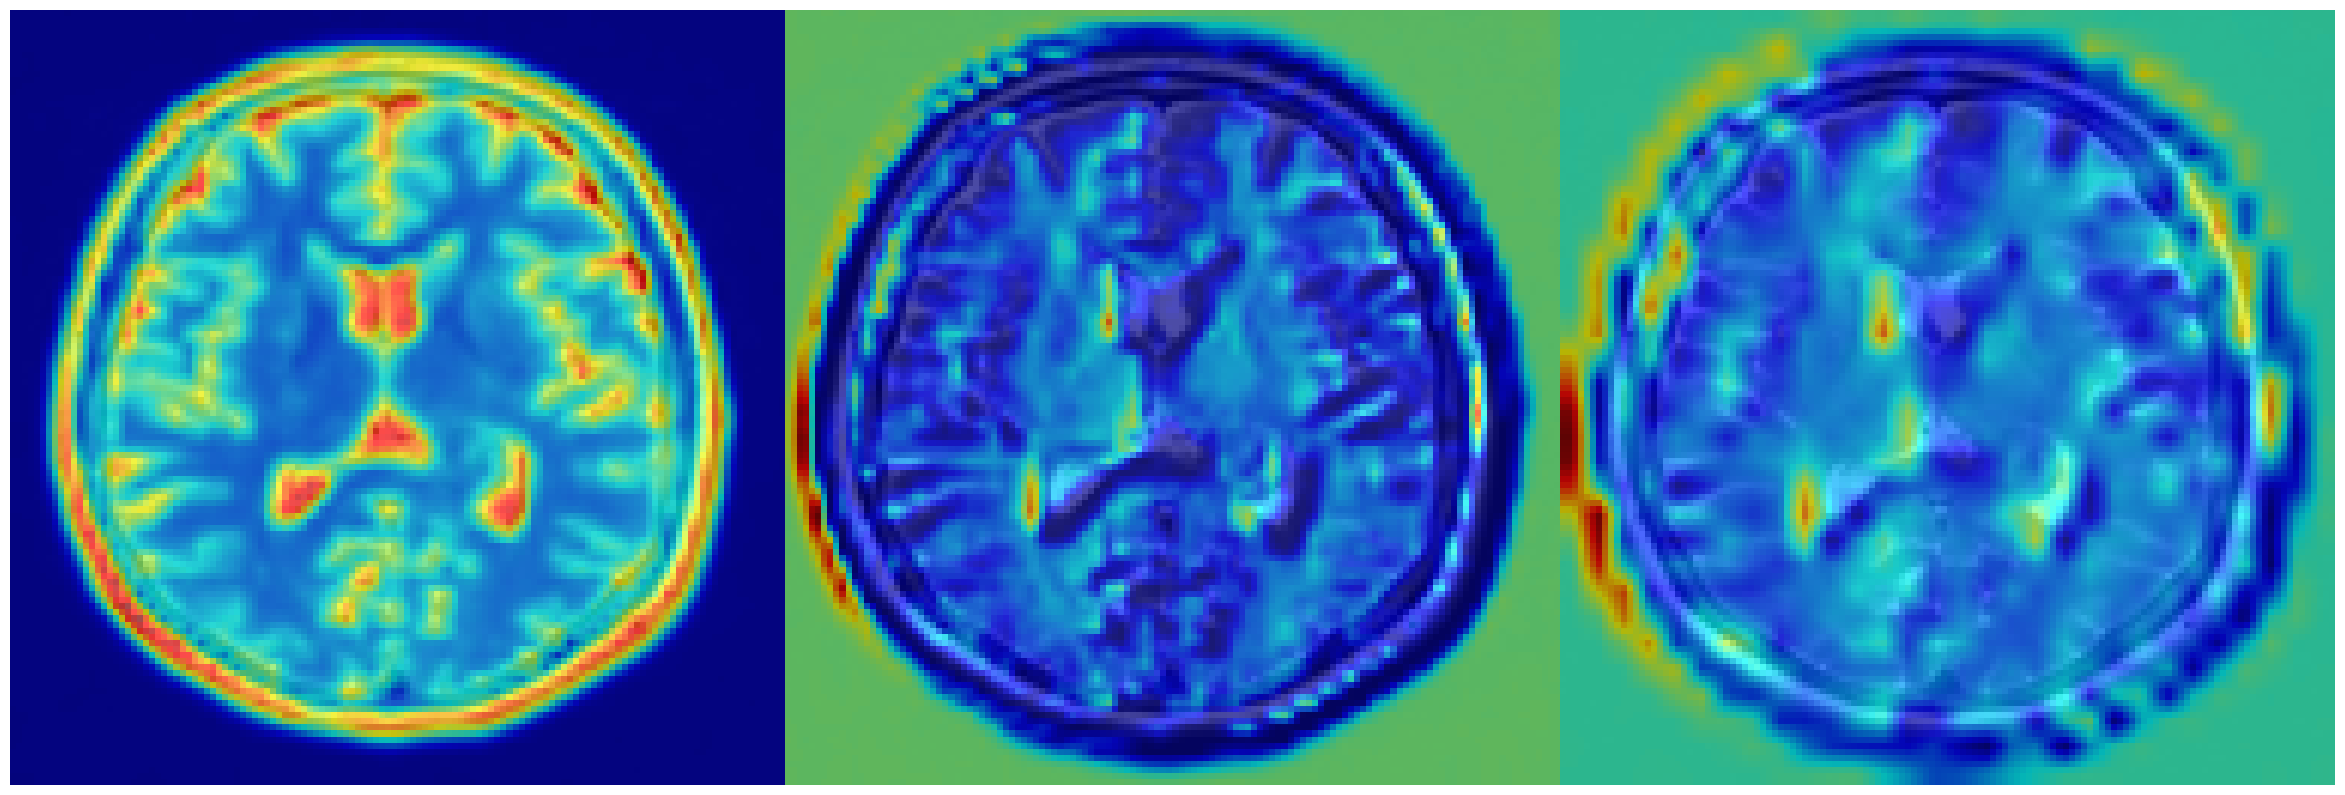

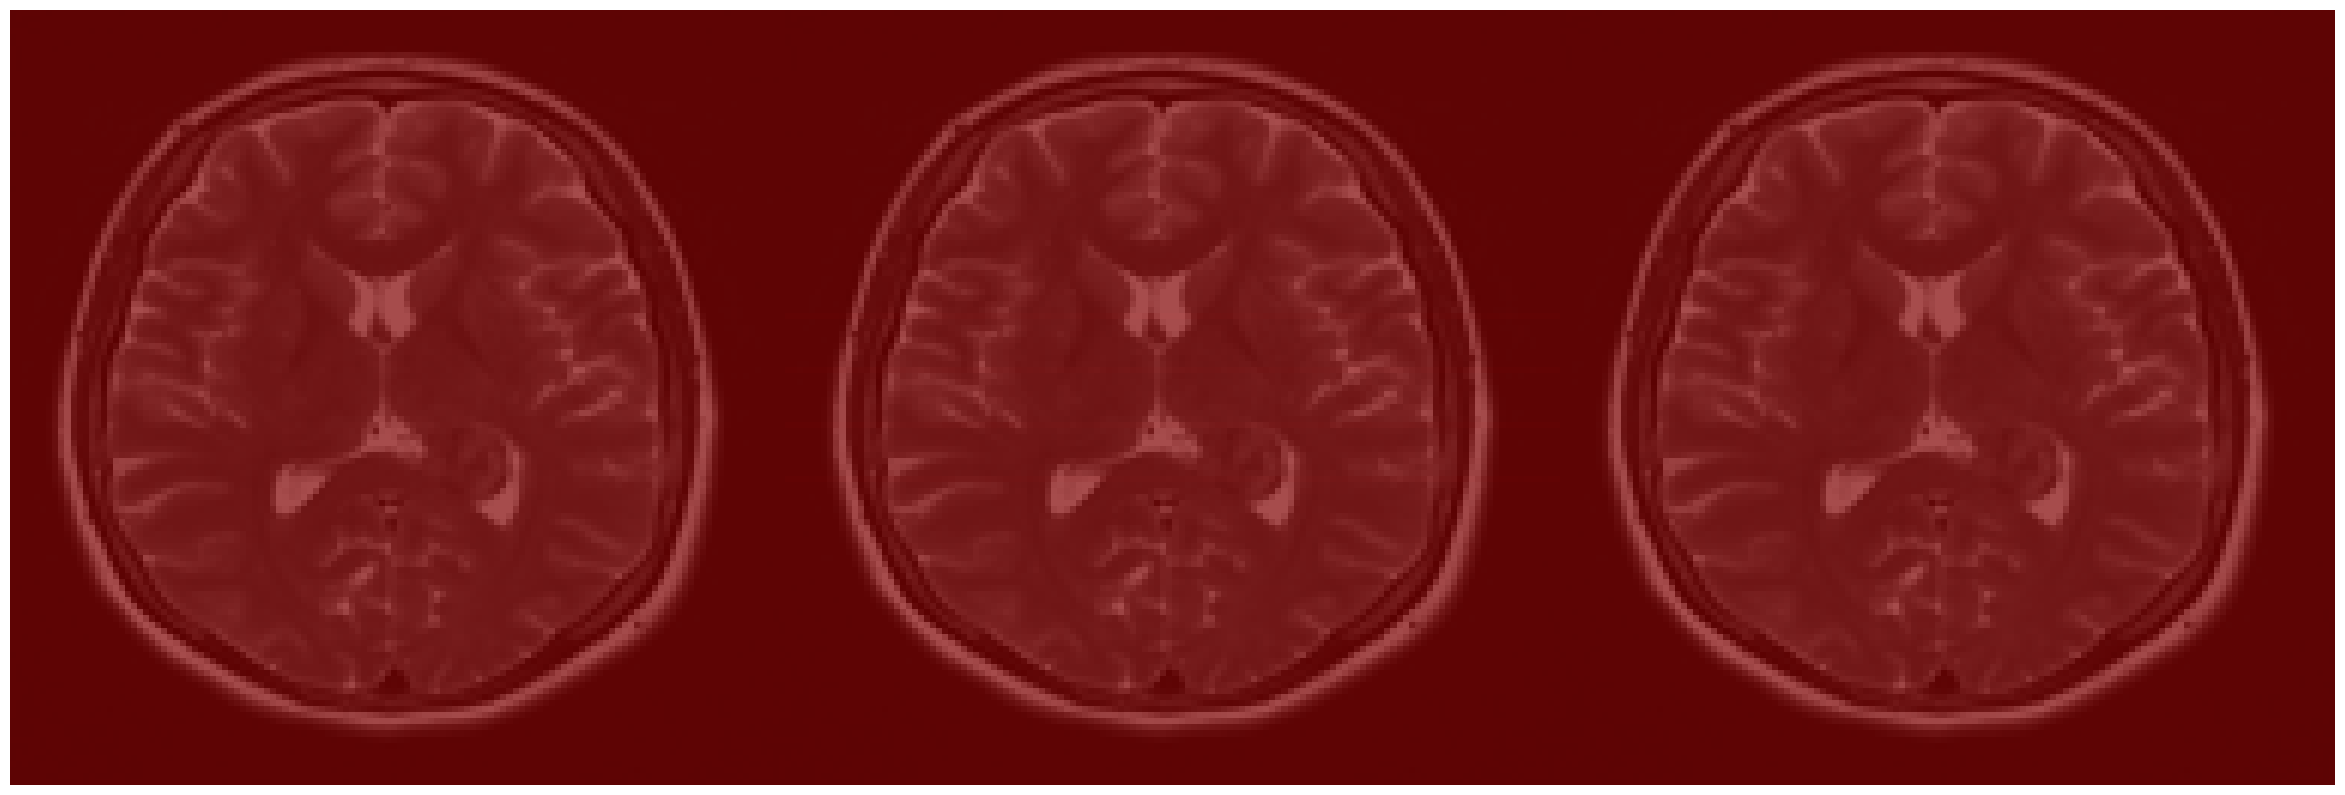

In [ ]:
plot_heatmaps(range(1, 4))
plot_heatmaps(range(4, 7))

## Generalization
* Data from [Kaggl Brain Tumor MRI Dataset[link text](https://)](https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset?select=Training).

Glioma - No equivalence
Meningioma - 24, 25, 26
No Tumor/ Normal 42, 43
Pitutary - No equivalence

In [ ]:
!kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset

100% 149M/149M [00:05<00:00, 34.0MB/s]
100% 149M/149M [00:05<00:00, 27.8MB/s]


In [ ]:
!unzip 'brain_tumor_2 2.zip' -d brain_tumor_general/

In [ ]:
# Function to load and preprocess the images, also get the label of class

def load_images_gen(folder_path):
    images = []
    labels = []
    label_names = []
    class_dirs = ["meningioma", "notumor"]

    for class_index, class_dir in enumerate(class_dirs):
        #if class_dir == "meningioma" or class_dir == "notumor":
        class_path = os.path.join(folder_path, class_dir)
        label_names.append(class_dir)
        if os.path.isdir(class_path):
            image_files = os.listdir(class_path)
            for image_file in image_files:
                if image_file.lower().endswith(".jpg"):
                    image_path = os.path.join(class_path, image_file)
                    image = Image.open(image_path).convert('RGB')
                    image = image.resize(img_size)
                    image = np.array(image)
                    images.append(image)
                    labels.append(class_index)

    return np.array(images), np.array(labels), label_names

In [ ]:
# Define the image size and number of classes
image_folder_gen = "brain_tumor_general/brain_tumor_2/Testing"

# Load and preprocess the images
images_gen, labels_gen, label_names_gen = load_images_gen(image_folder_gen)

In [ ]:
num_correct = 0
num_examples = len(images_gen)

for i in range(num_examples):
  # Preprocess a single image (e.g., normalize pixel values)
  image = images_gen[i] / 255.0

  # Resize the image to match the input size expected by the model
  resized_image = cv2.resize(image, img_size)

  # Add an extra dimension to match the expected input shape of the model
  input_image = np.expand_dims(resized_image, axis=0)

  # Make a prediction for the single image
  predictions = model.predict(input_image, verbose=0)

  # Convert the prediction into a class label (assuming it's a classification task)
  predicted_label = np.argmax(predictions[0])

  # check if it's meningioma
  if labels_gen[i] == 0:
    # check if predicted_label is 24, 25, or 26
    if predicted_label in [24, 25, 26]:
      num_correct += 1
  else:
    # check if predicted_label is 42 or 43
    if predicted_label in [42, 43]:
      num_correct += 1

generalization_accuracy = (num_correct / num_examples) * 100

print("The generalization accuracy is: %.4f%%" % generalization_accuracy)

The generalization accuracy is: 0.5618%
